# 1. To plot the Tangential and Normal vectors for NACA airfoil.

In [245]:
import numpy 
import math 
from scipy import integrate
from matplotlib import pyplot 

In [246]:
# free stream speed
u_inf = 1.0

In [247]:
# defines the cylinder
R = 1.0                                                           # radius
theta = numpy.linspace(0, 2*math.pi, 100)                         # angles in radians
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)   # coordinates of the cylinder


%matplotlib inline


In [248]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)

        self.beta = math.atan2((yb-ya),(xb-xa))
        
        self.sigma = 0.                             # source strength
        
        self.n= [-math.sin(self.beta), math.cos(self.beta)]  #Normal Vector
        self.t= [-math.cos(self.beta), -math.sin(self.beta)] # tangential vector
        self.cp = 0.                                # pressure coefficient
    

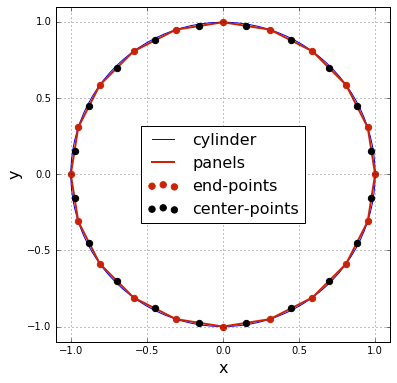

In [249]:
N_panels = 20                    # number of panels desired

# defining the end-points of the panels
x_ends = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

# defining the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plotting the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', s=40, zorder=3)
pyplot.legend(['cylinder', 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

In [250]:
#transforming into Joukowsky 

T  = 0.1
c = 1 
H = 0
a = c/4
theta = numpy.linspace(0, 2*math.pi, N_panels+1) 
Zeta_c = -4*a/(3*math.sqrt(3))*T+1j*2*H
r_s = ((1/4)+(T/(3*math.sqrt(3))))*c
 
Zeta = (r_s)*numpy.exp(1j*(theta))

J = (Zeta+Zeta_c) + a**2/(Zeta+Zeta_c)

x_ends = J.real
y_ends = J.imag

x_ends = x_ends[::-1]
y_ends = y_ends[::-1]

panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    

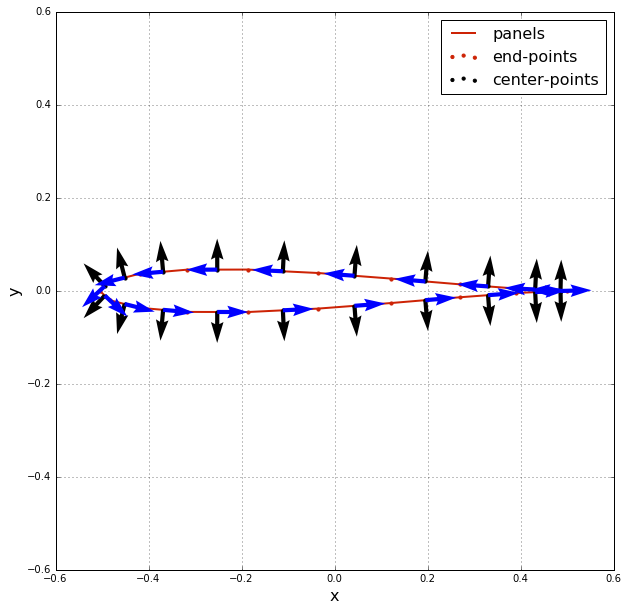

In [251]:

size = 10
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)

pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=10)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', s=10, zorder=3)
pyplot.axis("equal")

pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels] ,[p.n[1] for p in panels],color='k',zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.t[0] for p in panels] ,[p.t[1] for p in panels],color='b',zorder=3)

pyplot.legend([ 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})


# 2.To compute the induced velocity componenets from a constant strength panel

In [252]:
# Creating Meshgrid
N = 50
x_start, x_end = -1.5,1.5
y_start, y_end = -1.5,1.5
x = numpy.linspace(x_start, x_end, N)
y = numpy.linspace(y_start, y_end, N)
X, Y = numpy.meshgrid(x,y)

In [253]:
k = 1.0 #strength
panel = Panel(0.,0.01,0.5,0.15)
panel.sigma = k

In [254]:
def get_source_panel_velocity (panel,xp,yp):
    xpnew = (xp-panel.xb)*panel.t[0]+(yp-panel.yb)*panel.t[1] #rotation of coordinates
    ypnew = (xp-panel.xb)*panel.n[0]+(yp-panel.yb)*panel.n[1]
    
    xbnew = 0
    ybnew = 0
    
    xanew = (panel.xa-panel.xb)*panel.t[0]+(panel.ya-panel.yb)*panel.t[1] #new coordinates of the panels
    yanew = (panel.ya-panel.yb)*panel.n[1]+(panel.xa-panel.xb)*panel.n[0]
    
    #velocity in transformed and rotated coordinates
    u = (panel.sigma/(4*math.pi))*math.log(((xpnew-xbnew)**2+ypnew**2)/((xpnew-xanew)**2+ypnew**2),math.exp(1)) 
    v = (panel.sigma/(2*math.pi))*(math.atan2(ypnew,(xpnew-xanew))-math.atan2(ypnew,(xpnew-xbnew)))
    
    #Velocity in global coordinates
    unew = (u)*panel.n[1]+(v)*panel.n[0] 
    vnew = (u)*panel.t[1]+(v)*panel.t[0]
    
    return unew,vnew


In [255]:
u= numpy.zeros((N,N),dtype=float)
v= numpy.zeros((N,N),dtype=float)

for i in range (N):
    for j in range(N):
        u[i][j],v[i][j]= get_source_panel_velocity(panel,X[i][j],Y[i][j])

    
    

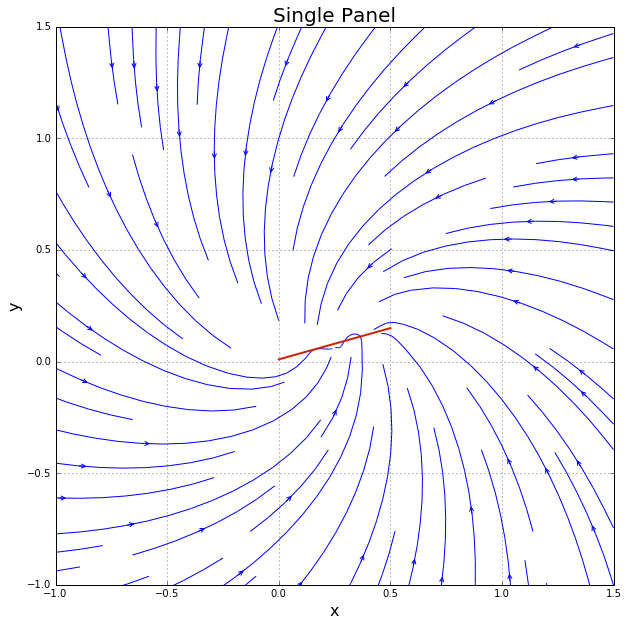

In [256]:
%matplotlib inline

size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.title('Single Panel', fontsize=20)
pyplot.xlim(-1, 1.5)
pyplot.ylim(-1, 1.5)
pyplot.streamplot(X, Y, u,v, density=1, linewidth=1, arrowsize=1, arrowstyle='->')

pyplot.plot( [0.0,0.5],[0.01,0.15], color='#CD2305', linestyle='-', linewidth=2)